       Лабораторная работа №1 по курсу "МРЗвИС" на тему "Сжатие графической информации линейной рециркуляционной сетью"  
                                           Выполнил Рудьман И.О. гр. 021701                                              

In [14]:
import os
from PIL import Image
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from random import randint
matplotlib.rcParams['figure.figsize'] = [5, 5]

In [2]:
#folder with images
datapath =  "C:\\Users\\Пользователь\\Desktop\\pngs"

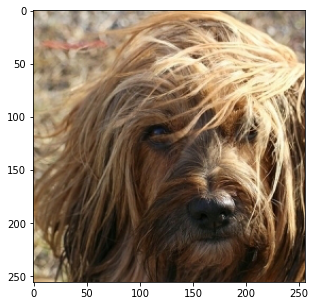

In [3]:
#image example
#plt.imshow can show array not only with numbers from 0 to 255, but also from 0 to 1
matplotlib.rcParams['figure.figsize'] = [5, 5]
plt.imshow(mpimg.imread(datapath+"\\1000.png"))

In [4]:
#show shape of picture before and after reshaping
pic_shape = mpimg.imread(datapath+"\\1.png").shape
vect_shape = mpimg.imread(datapath+"\\1.png").reshape(256*256*3).shape
print(pic_shape, vect_shape)

(256, 256, 3) (196608,)


In [5]:
#set image splitting params
#size of rectangles
n = 16 
m = 16
#size of original image
size = 256 
#num of rectangles 
horizontal = size//n
vertical = size//m
blocks_num = vertical*horizontal

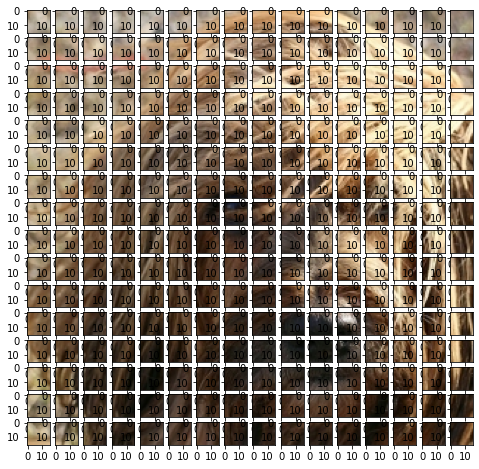

In [6]:
#split picture into rectangles
#may take a 15 secs
matplotlib.rcParams['figure.figsize'] = [8, 8]
fig, axs = plt.subplots(horizontal, vertical)
pic = mpimg.imread(datapath+"\\1000.png")
for i in range(horizontal):
    for j in range(vertical):
        axs[i,j].imshow(pic[n*i:n*(i+1),m*j:m*(j+1),:])

In [7]:
#preparing data
images_num = 1000
data = np.zeros((blocks_num*images_num, n*m*3))
for i in tqdm(range(images_num)):
    pic = mpimg.imread(datapath+f"\\{i+1}.png")
    for j in range(vertical):
        for k in range(horizontal):
            data[blocks_num*i+horizontal*j+k,:] = pic[m*j:m*(j+1),n*k:n*(k+1),:].reshape(n*m*3)*2-1
#num of flatted rectangles in dataset
print(len(data))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.90it/s]

256000


In [8]:
#main class
class NeuralNetwork:
    def __init__(self, n, m, Z, alpha = 5*10e-5):
        self.alpha = alpha
        self.encode_weights = np.random.normal(0.0, pow(3*m*n//Z, -0.5),(3*m*n,3*m*n//Z))
        self.decode_weights = self.encode_weights.T
        
    def train(self, pic):
        compressed = (pic@self.encode_weights)[np.newaxis]
        output = (compressed@self.decode_weights)
        error = (output - pic)
        self.decode_weights -=  self.alpha*(compressed.T@error)
        pic = pic[np.newaxis]
        self.encode_weights -= self.alpha*pic.T@error@self.decode_weights.T
        return error
    
    def test(self, pic):
        return self.decode(self.encode(pic))
        
    def encode(self, pic):
        splitted_pic = []
        #split image into squares
        for j in range(vertical):
                for k in range(horizontal):
                    splitted_pic.append(pic[m*j:m*(j+1),n*k:n*(k+1),:].reshape(n*m*3)*2-1)
        encoded_pic = []
        #encode pic
        for i in splitted_pic:
            encoded_pic.append(i@self.encode_weights)
        return np.array(encoded_pic)
        
    def decode(self, encoded):
        pic = np.zeros((size,size,3))
        for i in range(vertical):
            for j in range(horizontal):
                pic[i*m:(i+1)*m,j*n:(j+1)*n] = (encoded[i*m+j]@self.decode_weights).reshape(16,16,3)
        pic = (pic+1)/2
        return pic
            
            
    

In [9]:
def check_loss(splitted_pic):
    err = []
    for block in splitted_pic:
        err.append(block - N.test(i))
    return np.sum(np.array(err)**2)/size**2

In [10]:
#make sample of data
train_num = 20000
train = data[:train_num]

In [11]:
#create new network
alpha = 5*10e-5
error = 0.15
Z = 3
N = NeuralNetwork(n,m, Z, alpha = alpha)

In [54]:
#train network

# loss = []            
for image in tqdm(train):
    N.train(image)
    #loss.append(check_loss(splitted_pic))
    
# check loss
# ax = plt.gca()
# ax.set_ylim(0,1)
# plt.plot(range(len(loss)), loss)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:17<00:00, 63.05it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


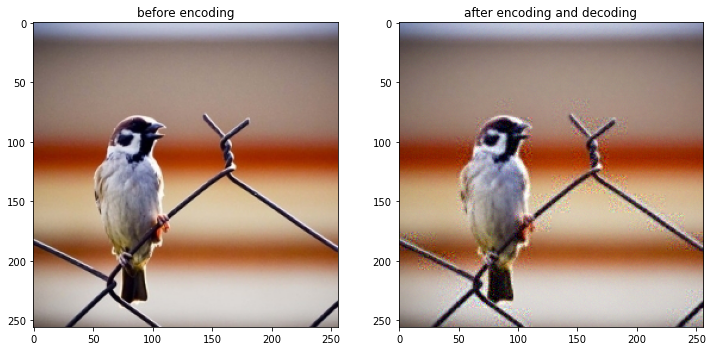

In [60]:
#network testing
matplotlib.rcParams['figure.figsize'] = [12, 12]

pic_num = randint(1,1000)
pic = mpimg.imread(datapath+f"\\{pic_num+1}.png")
test = N.test(pic)

fig, axs = plt.subplots(1,2)
axs[0].imshow(pic)
axs[1].imshow(test)
axs[0].set_title("before encoding")
axs[1].set_title("after encoding and decoding");

In [57]:
#save weights 
np.save(r"C:\Users\Пользователь\Desktop\encode_weights.npy", N.encode_weights)
np.save(r"C:\Users\Пользователь\Desktop\decode_weights.npy", N.decode_weights)

In [59]:
#load weights 
N.encode_weights = np.load(r"C:\Users\Пользователь\Desktop\encode_weights.npy")
N.decode_weights = np.load(r"C:\Users\Пользователь\Desktop\decode_weights.npy")

In [62]:
#estimate the memory usage

#get the size of network weights 
weights_size = os.stat(r"C:\Users\Пользователь\Desktop\encode_weights.npy").st_size
weights_size += os.stat(r"C:\Users\Пользователь\Desktop\decode_weights.npy").st_size
print("weights size:", weights_size//1024**2,"MBs")

#let get the size of 1000 of images in dataset
images_size = 0
for i in range(1000):
    images_size += os.stat(datapath+f"\\{i+1}.png").st_size
print("images size:" , images_size//1024**2,"MBs")

#next encode all this images and check their size
encoded_images_size = 0
for i in tqdm(range(1000)):
    pic = mpimg.imread(datapath+f"\\{i+1}.png")
    
    #reshape encoded data and convert it to png to estimate compression 
    pic = N.encode(pic)
    while pic.shape[0]%3!=0 or int((pic.shape[0]/3)**0.5)!=(pic.shape[0]/3)**0.5:
        pic = np.append(pic, 0)
    pic = (pic.reshape(int((pic.shape[0]/3)**0.5),int((pic.shape[0]/3)**0.5), 3)*255).astype(np.uint8)
    im = Image.fromarray(pic)
    im.save(f"C:\\Users\\Пользователь\\Desktop\\encoded\\pic{i+1}.png")
    encoded_images_size+=os.stat(f"C:\\Users\\Пользователь\\Desktop\\encoded\\pic{i+1}.png").st_size

print("encoded_images_size", encoded_images_size//1024**2,"MBs")

weights size: 3 MBs
images size: 109 MBs


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.85it/s]

encoded_images_size 62 MBs


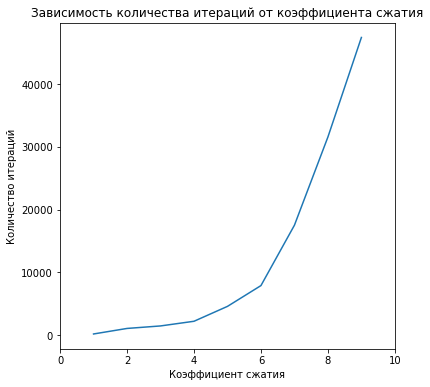

In [40]:
matplotlib.rcParams['figure.figsize'] = [6, 6]
ax = plt.gca()
ax.set_xlim(0,10)
ax
Zs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
iters = [164, 1046, 1445, 2189, 4563, 7877, 17500, 31557, 47420]
plt.title("Зависимость количества итераций от коэффициента сжатия")
plt.xlabel("Коэффициент сжатия")
plt.ylabel("Количество итераций")
plt.plot(Zs, iters)

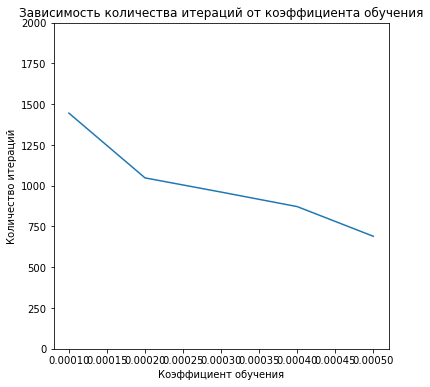

In [42]:
matplotlib.rcParams['figure.figsize'] = [6, 6]
ax = plt.gca()
ax.set_ylim(0,2000)
alphas = [10e-5,2*10e-5,3*10e-5, 4*10e-5, 5*10e-5]
iters = [1445, 1048, 961, 872, 690]
plt.title("Зависимость количества итераций от коэффициента обучения")
plt.xlabel("Коэффициент обучения")
plt.ylabel("Количество итераций")
plt.plot(alphas, iters)

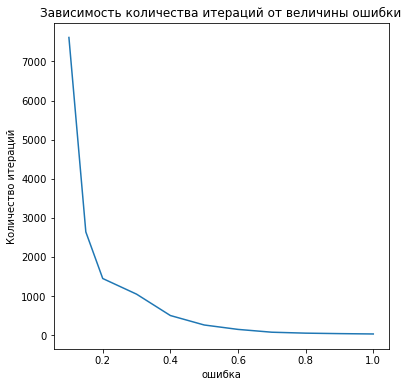

In [41]:
matplotlib.rcParams['figure.figsize'] = [6,6]
ax = plt.gca()
errors = [1,0.9,0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.15, 0.1]
iters = [26, 35, 47, 71, 143, 256, 498, 1045, 1445,2637, 7613]
plt.title("Зависимость количества итераций от величины ошибки")
plt.xlabel("ошибка")
plt.ylabel("Количество итераций")
plt.plot(errors, iters)